In [1]:
%reload_ext autoreload
%autoreload 1
from ray import tune, train
import shap
import matplotlib.pyplot as plt
import polars as pl
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_manipulation_functions as dmf
import functions.plot_functions as pf
import functions.tuning as tunes
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
%aimport functions.tuning
%aimport functions.transformers
%aimport functions.data_manipulation_functions
%aimport functions.plot_functions

In [2]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

In [3]:
data_sample_train=pl.read_parquet('data/data_sample.parquet')
data_sample_val=pl.read_parquet('data/data_sample.parquet')

In [4]:
data_sample_train=dmf.title_text_features(data_sample_train)
data_sample_val=dmf.title_text_features(data_sample_val)

In [5]:
X_mini_train = data_sample_train.drop(columns=['Application Date','month','Policy Code'])
X_mini_val= data_sample_val.drop(columns=['Application Date','month','Policy Code'])
y_mini_train = data_sample_train['Policy Code']
y_mini_val= data_sample_val['Policy Code']

# stop here

In [6]:
title_cat_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)
zip_imputer=tr.NotInImputerPolars(cat_no=50,fill_value=None)
state_imputer=tr.NotInImputerPolars(cat_no=50,fill_value=None)
emp_length_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)

imputer = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(title_cat_imputer, "title"),
        tr.PolarsColumnTransformer.Step(zip_imputer, "Zip Code"),
        tr.PolarsColumnTransformer.Step(state_imputer, "State"),
        tr.PolarsColumnTransformer.Step(emp_length_imputer, "Employment Length"),
    ]
)

In [7]:
state_encoder = tr.PolarsOneHotEncoder()
zip_encoder = tr.PolarsOneHotEncoder()
title_encoder = tr.PolarsOneHotEncoder()
length_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]

employment_encoder=tr.PolarsOrdinalEncoder(order=length_order)
encoder = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(state_encoder, "State"),
        tr.PolarsColumnTransformer.Step(zip_encoder, "Zip Code"),
        tr.PolarsColumnTransformer.Step(title_encoder, "title"),
        tr.PolarsColumnTransformer.Step(employment_encoder, "Employment Length"),
    ]
)
null_imp=tr.PolarsNullImputer(fill_value=-1)


model_lgbm = lgb.LGBMClassifier(
    class_weight="balanced", force_col_wise=True, verbose=-1, num_threads=1,random_state=1
)

boruta=tr.BorutaFeatureSelectorPolars(model_lgbm,random_state=1,perc=70)

preprocess_lgbm = Pipeline([("imputer", imputer), ("encoder", encoder),("null_imputer", null_imp), ("boruta", boruta)])

In [8]:

full_pipeline = Pipeline(
    [
        ("preprocess", preprocess_lgbm),
        ("model", model_lgbm),
    ]
)

In [10]:
search_space_lgbm = {
    "preprocess__boruta__perc": tune.randint(1,100),
    "model__num_leaves": tune.randint(10, 200),
    "model__n_estimators": tune.randint(10, 250),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 1.0),
    "model__reg_lambda": tune.loguniform(0.001, 1.0),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
}

models=tunes.Models()
models.add_model('lgbm_yn',full_pipeline,search_space_lgbm)


models.tune_all(X_mini_train,y_mini_train,X_mini_val,y_mini_val,n=20)

(Trainable pid=27641) {'preprocess__boruta__perc': 53, 'model__num_leaves': 109, 'model__n_estimators': 104, 'model__learning_rate': 0.00451217459851064, 'model__colsample_bytree': 0.8855822362201295, 'model__subsample': 0.42989917167774216, 'model__reg_alpha': 0.0021411149295712676, 'model__reg_lambda': 0.0016299097028179045, 'model__boosting_type': 'dart'}
(Trainable pid=27699) {'preprocess__boruta__perc': 45, 'model__num_leaves': 132, 'model__n_estimators': 165, 'model__learning_rate': 0.005167628823572921, 'model__colsample_bytree': 0.9337739337022477, 'model__subsample': 0.8981425675998684, 'model__reg_alpha': 0.7273546591772069, 'model__reg_lambda': 0.5770019915204856, 'model__boosting_type': 'rf'}
(Trainable pid=27850) {'preprocess__boruta__perc': 20, 'model__num_leaves': 174, 'model__n_estimators': 213, 'model__learning_rate': 0.02563428665014348, 'model__colsample_bytree': 0.28049267822529206, 'model__subsample': 0.6574077295345169, 'model__reg_alpha': 0.0010873351077584719, '

2023-10-02 12:45:35,361	WARNING tune.py:194 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
(Trainable pid=28178) Traceback (most recent call last):
(Trainable pid=28178)   File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
(Trainable pid=28178)   File "/home/gediminas/anaconda3/lib/python3.9/site-packages/ray/_private/function_manager.py", line 726, in actor_method_executor
(Trainable pid=28178)     return method(__ray_actor, *args, **kwargs)
(Trainable pid=28178)   File "/home/gediminas/anaconda3/lib/python3.9/site-packages/ray/util/tracing/tracing_helper.py", line 467, in _resume_span
(Trainable pid=28178)     return method(self, *_args, **_kwargs)
(Trainable pid=28178)   File "/home/gediminas/anaconda3/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 397, in train
(Trainable pid=28178)  

lgbm_yn tuned:


(Trainable pid=29180) Traceback (most recent call last):
(Trainable pid=29180)   File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
(Trainable pid=29180)   File "/home/gediminas/anaconda3/lib/python3.9/site-packages/ray/_private/function_manager.py", line 726, in actor_method_executor
(Trainable pid=29180)     return method(__ray_actor, *args, **kwargs)
(Trainable pid=29180)   File "/home/gediminas/anaconda3/lib/python3.9/site-packages/ray/util/tracing/tracing_helper.py", line 467, in _resume_span
(Trainable pid=29180)     return method(self, *_args, **_kwargs)
(Trainable pid=29180)   File "/home/gediminas/anaconda3/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 397, in train
(Trainable pid=29180)     result = self.step()
(Trainable pid=29180)   File "/home/gediminas/anaconda3/lib/python3.9/site-packages/ray/util/tracing/tracing_helper.py", line 467, in _resume_span
(Trainable pid=29180)     return method(self, *_args, **_kwargs)

In [ ]:
models.models['lgbm_yn'].best_params

{'preprocess__boruta__perc': 9,
 'model__num_leaves': 164,
 'model__n_estimators': 217,
 'model__learning_rate': 0.013337937864470057,
 'model__colsample_bytree': 0.5455502509393735,
 'model__subsample': 0.695220290584837,
 'model__reg_alpha': 0.002951966341883236,
 'model__reg_lambda': 0.010377165047401552,
 'model__boosting_type': 'gbdt'}

In [9]:
full_pipeline.fit(X_mini_train,y_mini_train)
#models.models['lgbm_yn'].pipeline.fit(X_mini_train,y_mini_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  PolarsColumnTransformer(steps=[<functions.transformers.PolarsColumnTransformer.Step object at 0x7f8c142a95b0>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7f8c142a9d30>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7f8c142a9520>,
                                                                 <functions.transformers.PolarsColu...
                                 ('boruta',
                                  BorutaFeatureSelectorPolars(estimator=LGBMClassifier(class_weight='balanced',
                                                                                       force_col_wise=True,
                                                                                       num_threads=1,
                                                                                       random_state=RandomState(MT19937) at 0x7F8BB4FC6840,
                                                                                       verbose=-1),
                                                              perc=70,
                                                              random_state=1))])),
                ('model',
                 LGBMClassifier(class_weight='balanced', force_col_wise=True,
                                num_threads=1,
                                random_state=RandomState(MT19937) at 0x7F8BB4FC6840,
                                verbose=-1))])

In [10]:
preds=full_pipeline.predict(X_mini_val)#models.models['lgbm_yn'].pipeline.predict(X_mini_val)

In [11]:
print(classification_report(y_mini_val,preds))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     46221
           1       0.51      0.92      0.66      3779

    accuracy                           0.93     50000
   macro avg       0.75      0.93      0.81     50000
weighted avg       0.96      0.93      0.94     50000



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


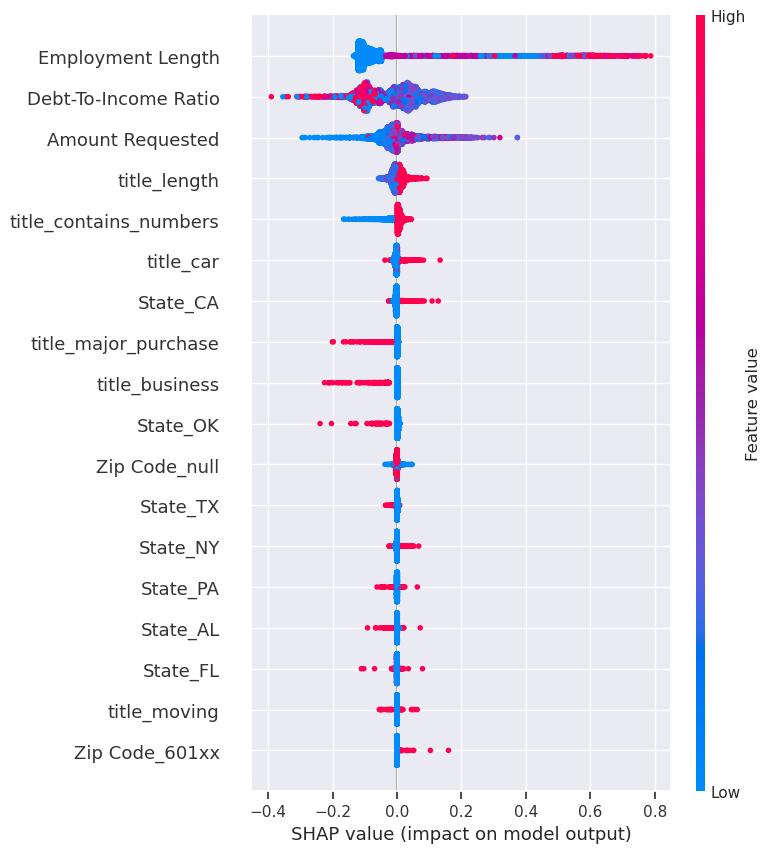

In [13]:
names = full_pipeline["preprocess"].transform(X_mini_val.sample(5000, seed=1)).columns
explainer_tree = shap.TreeExplainer(
    full_pipeline["model"],
    data=full_pipeline["preprocess"]
    .transform((X_mini_val.sample(100, seed=1)))
    .to_numpy(),
    model_output="probability",
)

shap_values = explainer_tree.shap_values(
    full_pipeline["preprocess"].transform(X_mini_val.sample(5000, seed=1)).to_numpy()
)

shap.summary_plot(
    shap_values,
    full_pipeline["preprocess"].transform(X_mini_val.sample(5000, seed=1)).to_numpy(),
    feature_names=names,
    max_display=20,
)

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# dtree=DecisionTreeClassifier()
# full_pipeline_dtree= Pipeline(
#     [
#         ("preprocess", Pipeline([("imputer", imputer), ("encoder", encoder), ("null_imputer", imp)])),
#         ("model", dtree),
#     ]
# )

In [ ]:
# full_pipeline_dtree.fit(X_mini_train, y_mini_train)
# preds_dtree = full_pipeline_dtree.predict(X_mini_val)
# print(classification_report(y_mini_val, preds_dtree))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     13866
           1       0.53      0.53      0.53      1134

    accuracy                           0.93     15000
   macro avg       0.75      0.75      0.75     15000
weighted avg       0.93      0.93      0.93     15000

